# CAPP 30255 1 Advanced Machine Learning for PP
## Measuring Political Compatibility with node2vec and moral values scale
### Software Demonstration: Minimum Viable Product
### Authors: Andrei Bartra and Oscar Noriega


In [1]:
# Basics
import os, sys

#Other libraries
import time
import pandas as pd
import numpy as np

#Special Libraries
from emfdscore.scoring import score_docs


#Path Settings
wd = os.getcwd()
os.chdir(wd)
sys.path.append(os.chdir(wd))

sys.path.insert(0, './ws')
sys.path.insert(1, './dc')

#Local modules
import ws_rev_scrapper_ipynb as ws

#Trainning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

Loading Web Scrapper Lord andre


## Data Extraction: Web Scrapping:

In [2]:
#ws.crawler(load_time=1, test=1)


## Data Processing
Run in WSL
Coult not make it run in Conda :(

## Data Characteristics

(112200, 17)


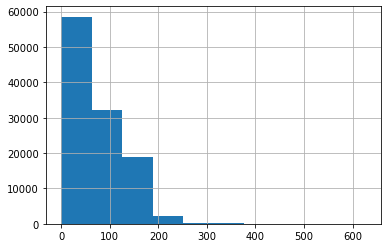

In [3]:
df = pd.read_csv(r'D:\Google Drive\U Chicago\8. Q6\AML\Project\data\raw_output\emfd_out.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['speech'] = df['speech'].fillna('')
df["length"] = [len(x.split()) for x in df['speech'].tolist()] 
df['count'] = df['speaker'].map(df['speaker'].value_counts())
df.head()
df.length.hist()
print(df.shape)

(77826, 17)


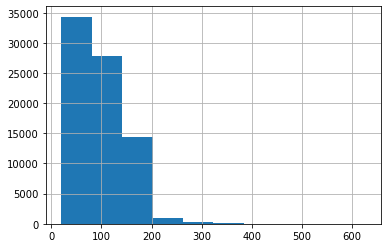

In [4]:
df = df.loc[df.length >= 20]
df.length.hist()
print(df.shape)

<AxesSubplot:>

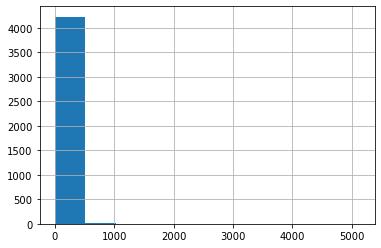

In [5]:
spkr = df.groupby('speaker')['count'].count()
spkr.hist()

(33881, 17)
(54,)


<AxesSubplot:>

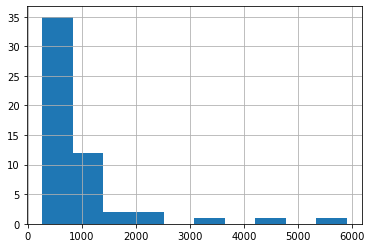

In [6]:
df = df.loc[df['count']>=268]
spkr = df.groupby('speaker')['count'].max()
print(df.shape)
print(spkr.shape)
spkr.hist()

In [7]:
pd.set_option('display.max_rows', None)
spkr.sort_values(ascending=False)


speaker
Donald Trump                 5892.0
Jen Psaki                    4767.0
Joe Biden                    3585.0
Speaker 1                    2101.0
Speaker 2                    2043.0
Speaker 3                    1698.0
Speaker 4                    1396.0
President Donald Trump       1334.0
Speaker 5                    1200.0
Nancy Pelosi                 1146.0
Andrew Cuomo                 1130.0
Mike Pence                   1129.0
President Trump              1089.0
Speaker 6                     901.0
Gov. Mike DeWine              881.0
Boris Johnson                 875.0
Speaker 7                     852.0
Governor DeWine               844.0
Kamala Harris                 833.0
Governor Cuomo                811.0
Mike DeWine                   768.0
Speaker 8                     754.0
Governor Mike DeWine          744.0
Governor Andrew Cuomo         701.0
President Donald J. Trump     687.0
Speaker 9                     685.0
Speaker 10                    639.0
Gavin Newsom        

In [8]:
df.loc[df['speaker'].str.contains("Pelosi"), 'speaker'] = 'Nancy Pelosi'
drop = ['speaker', 'Speaker', 'Crowd', 'Chair Hall', 'Operator', 'Audience']
replace = ['Trump', 'Pence', 'Cuomo', 'DeWine', 'Biden', 'Psaki', 'Newsom']


df = df.drop(df[df['speaker'].str.contains('|'.join(drop), regex=True)].index)
for rep in replace:
    df['speaker'] = df['speaker'].apply(lambda x: rep if rep in x else x)

spkr = df.groupby('speaker')['count'].max()
spkr.sort_values(ascending=False)


speaker
Trump               5892.0
Psaki               4767.0
Biden               3585.0
Nancy Pelosi        1146.0
Cuomo               1130.0
Pence               1129.0
DeWine               881.0
Boris Johnson        875.0
Kamala Harris        833.0
Newsom               604.0
Kayleigh McEnany     559.0
Rudy Giuliani        545.0
Jerome Powell        511.0
Kevin McCarthy       459.0
Gabriel Sterling     419.0
Daniel Andrews       397.0
Ned Price            348.0
Chuck Schumer        346.0
Lindsey Graham       344.0
Dr. Fauci            341.0
Mitch McConnell      336.0
Mr. Comey            285.0
Vladimir Putin       276.0
Eric Nelson          274.0
Barack Obama         268.0
Name: count, dtype: float64

## The MVP Model
Minimun Viable Product

It is not what we want; it is what we can 

### Some Features

In [9]:
df = df.drop(['length', 'count'], axis=1)
X = [var for var in df.columns if var not in ['speaker', 'speech']]
for var in X:
    df[var+'_2'] = df[var]**2
X = [var for var in df.columns if var not in ['speaker', 'speech']]

### Resampling to balance data
Normalizing to 1000 records per speaker

In [10]:
df['rnd'] = np.random.uniform(size=len(df))

Under sampling

In [11]:
df = df.sort_values(['speaker', 'rnd'])
df['speech_id'] = df.groupby('speaker')['rnd'].rank(method='first', ascending=True)
df = df.loc[df['speech_id'] <= 1000]
df.shape

(13333, 30)

Over sampling

In [13]:
df['temp'] = round(df['speech_id']*1000/df.groupby('speaker')['rnd'].transform('count'))
df['repeat'] = df['temp'] - df.groupby('speaker')['temp'].shift(1)
df['repeat'] = df.loc[:, ['temp', 'repeat']].apply(lambda x: x[0] if np.isnan(x[1]) else x[1], axis=1 ).astype(int)
df = df.loc[df.index.repeat(df.repeat)]


In [14]:
df.groupby('speaker')['rnd'].count()

speaker
Barack Obama        1000
Biden               1000
Boris Johnson       1000
Chuck Schumer       1000
Cuomo               1000
Daniel Andrews      1000
DeWine              1000
Dr. Fauci           1000
Eric Nelson         1000
Gabriel Sterling    1000
Jerome Powell       1000
Kamala Harris       1000
Kayleigh McEnany    1000
Kevin McCarthy      1000
Lindsey Graham      1000
Mitch McConnell     1000
Mr. Comey           1000
Nancy Pelosi        1000
Ned Price           1000
Newsom              1000
Pence               1000
Psaki               1000
Rudy Giuliani       1000
Trump               1000
Vladimir Putin      1000
Name: rnd, dtype: int64

### Splitting

In [15]:

train, valid, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.95*len(df))])
print(train.shape)
print(valid.shape)
print(test.shape)

(20000, 32)
(3750, 32)
(1250, 32)


### Helper Functions

In [16]:
Vocab_char = {}
Vocab_char[0] = '<unk>'
i=1
for char in train['speaker'].unique():
    Vocab_char[i] = char
    i+=1

def get_key(val):
    for key, value in Vocab_char.items():
        if val == value:
            return key

def preprocess_data(df):
    rv = []
    records = df.loc[:, X].to_records(index=False)
    results = list(records)
    for i in range(len(df)):
        rv.append((df['speaker'].iloc[i], results[i]))
    return rv

def collate_fn(batch):
    
    speech_mf = []
    labels = []
    
    for b in batch:
        label = get_key(b[0])
        labels.append(label)
        s = [i for i in b[1]]
        speech_mf.append(s)
    speech_mf = torch.tensor(speech_mf)
    labels = torch.tensor(labels)
    
    return labels, speech_mf
    

### Neural Net (5 hidden layers + softmax)

In [17]:
num_labels = len(Vocab_char)
vocab_size = len(X)

class NNeMFDTagger(nn.Module):
    def __init__(self, num_labels, vocab_size, hidden_dim, drop_probs, nonlinearity):

        super(NNeMFDTagger, self).__init__()
        self.dp = [nn.Dropout(p=prob) for prob in  drop_probs]
        self.nonlinearity = nonlinearity
        self.linear1 = nn.Linear(vocab_size, hidden_dim[0])
        self.linear2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.linear3 = nn.Linear(hidden_dim[1], hidden_dim[2])
        self.linear4 = nn.Linear(hidden_dim[2], hidden_dim[3])
        self.linear5 = nn.Linear(hidden_dim[3], hidden_dim[4])
        self.linear6 = nn.Linear(hidden_dim[4], num_labels)


    def forward(self, _input):
        f = self.dp[0](_input)
        h1 = self.nonlinearity[0](self.linear1(f))
        h1 = self.dp[1](h1)
        h2 = self.nonlinearity[1](self.linear2(h1))
        h2 = self.dp[2](h2)
        h3 = self.nonlinearity[2](self.linear3(h2))
        h3 = self.dp[3](h3)
        h4 = self.nonlinearity[3](self.linear4(h3))
        h4 = self.dp[4](h4)
        h5 = self.nonlinearity[4](self.linear5(h4))
        return F.log_softmax(self.linear6(h5), dim=1)

In [18]:
loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model.train()
    log_interval = 500

    for idx, (label, speech_mf) in enumerate(dataloader):
        model.zero_grad()
        probs = model(speech_mf.float())
        loss = loss_function(probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [19]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        for idx, (label, speech_mf) in enumerate(dataloader):
            log_probs = model(speech_mf.float())
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [20]:
BATCH_SIZE = 64 
  
train_data = preprocess_data(train)
valid_data = preprocess_data(valid)
test_data = preprocess_data(test)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

### Trainning Algorithm

In [21]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

def train_algo(epochs, lr, milestones=[10,20,25], gamma=0.1, opt_algo='SGD'):

    optimizer = torch.optim.SGD(model.parameters(), lr=lr) if opt_algo=='SGD' else \
                torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    valid_accuracies = []
    train_accuracies = []
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_an_epoch(train_dataloader, optimizer)
        valid_acc = get_accuracy(valid_dataloader)
        train_acc = get_accuracy(train_dataloader)
        valid_accuracies.append(valid_acc)
        train_accuracies.append(train_acc)
        scheduler.step()
        time_taken = time.time() - epoch_start_time
        print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {valid_acc:.3f}.')

    plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy')
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracies')
    plt.legend()
    plt.show()

Epoch: 1, time taken: 5.6s, validation accuracy: 0.043.
Epoch: 2, time taken: 3.2s, validation accuracy: 0.041.
Epoch: 3, time taken: 3.4s, validation accuracy: 0.040.
Epoch: 4, time taken: 3.1s, validation accuracy: 0.037.
Epoch: 5, time taken: 3.1s, validation accuracy: 0.042.
Epoch: 6, time taken: 3.1s, validation accuracy: 0.039.
Epoch: 7, time taken: 3.1s, validation accuracy: 0.039.
Epoch: 8, time taken: 3.1s, validation accuracy: 0.041.
Epoch: 9, time taken: 3.2s, validation accuracy: 0.042.
Epoch: 10, time taken: 3.1s, validation accuracy: 0.040.
Epoch: 11, time taken: 3.0s, validation accuracy: 0.032.
Epoch: 12, time taken: 3.2s, validation accuracy: 0.038.
Epoch: 13, time taken: 3.4s, validation accuracy: 0.038.
Epoch: 14, time taken: 3.1s, validation accuracy: 0.044.
Epoch: 15, time taken: 3.2s, validation accuracy: 0.046.
Epoch: 16, time taken: 5.3s, validation accuracy: 0.038.
Epoch: 17, time taken: 5.4s, validation accuracy: 0.040.
Epoch: 18, time taken: 4.3s, validation 

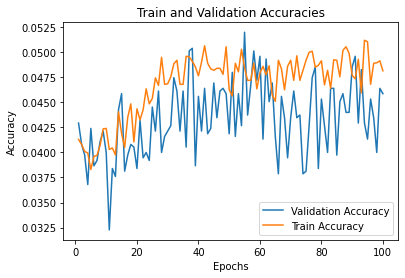

So we finally get a terrible accuracy: 0.0616


In [22]:
model = NNeMFDTagger(num_labels,
                     vocab_size,
                     hidden_dim=[100, 300, 500, 100, 50],
                     drop_probs = [0.9, 0.8, 0.5, 0.3, 0.1],
                     nonlinearity = [nn.Tanh(), nn.LeakyReLU(0.001), nn.LeakyReLU(0.001), nn.LeakyReLU(0.001), nn.LeakyReLU(0.001)])
train_algo(100, 1e-4, milestones=[30,60,90], gamma=0.01, opt_algo='Adam')
print('So we finally get a terrible accuracy: {}'.format(get_accuracy(test_dataloader)))

Epoch: 1, time taken: 3.7s, validation accuracy: 0.044.
Epoch: 2, time taken: 3.9s, validation accuracy: 0.049.
Epoch: 3, time taken: 4.4s, validation accuracy: 0.045.
Epoch: 4, time taken: 3.9s, validation accuracy: 0.043.
Epoch: 5, time taken: 4.3s, validation accuracy: 0.041.
Epoch: 6, time taken: 3.2s, validation accuracy: 0.046.
Epoch: 7, time taken: 3.2s, validation accuracy: 0.041.
Epoch: 8, time taken: 3.5s, validation accuracy: 0.045.
Epoch: 9, time taken: 3.2s, validation accuracy: 0.045.
Epoch: 10, time taken: 3.4s, validation accuracy: 0.047.
Epoch: 11, time taken: 3.1s, validation accuracy: 0.044.
Epoch: 12, time taken: 3.3s, validation accuracy: 0.047.
Epoch: 13, time taken: 3.2s, validation accuracy: 0.051.
Epoch: 14, time taken: 3.1s, validation accuracy: 0.043.
Epoch: 15, time taken: 3.2s, validation accuracy: 0.047.
Epoch: 16, time taken: 3.2s, validation accuracy: 0.043.
Epoch: 17, time taken: 3.2s, validation accuracy: 0.045.
Epoch: 18, time taken: 3.2s, validation 

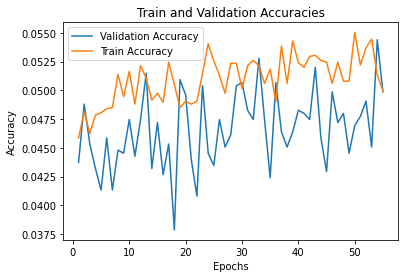

In [23]:
train_algo(55, 1e-4, milestones=[30], gamma=0.01, opt_algo='Adam')

Epoch: 1, time taken: 5.7s, validation accuracy: 0.047.
Epoch: 2, time taken: 3.6s, validation accuracy: 0.047.
Epoch: 3, time taken: 3.4s, validation accuracy: 0.057.
Epoch: 4, time taken: 3.1s, validation accuracy: 0.043.
Epoch: 5, time taken: 2.9s, validation accuracy: 0.048.
Epoch: 6, time taken: 3.0s, validation accuracy: 0.049.
Epoch: 7, time taken: 3.3s, validation accuracy: 0.048.
Epoch: 8, time taken: 2.9s, validation accuracy: 0.050.
Epoch: 9, time taken: 2.9s, validation accuracy: 0.053.
Epoch: 10, time taken: 2.8s, validation accuracy: 0.043.
Epoch: 11, time taken: 2.9s, validation accuracy: 0.042.
Epoch: 12, time taken: 2.8s, validation accuracy: 0.047.
Epoch: 13, time taken: 2.9s, validation accuracy: 0.050.
Epoch: 14, time taken: 2.9s, validation accuracy: 0.049.
Epoch: 15, time taken: 3.7s, validation accuracy: 0.047.
Epoch: 16, time taken: 4.2s, validation accuracy: 0.049.
Epoch: 17, time taken: 3.9s, validation accuracy: 0.047.
Epoch: 18, time taken: 3.3s, validation 

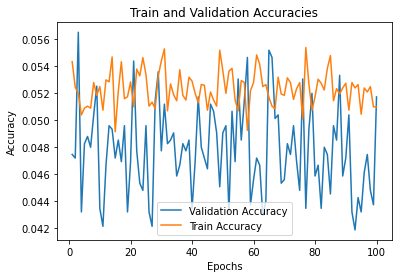

In [24]:
train_algo(100, 1e-4, milestones=[30,60,90], gamma=0.01, opt_algo='SGD')

In [26]:
print('And an even worse accuracy: {}'.format(get_accuracy(test_dataloader)))

And an even worse accuracy: 0.044
